In [2]:
import numpy as np
import h5py as h5
from os.path import join

from dynfriction import DF

from dynhalo.corrfunc.model import power_law

# init DF

In [3]:
filepath = "/spiff/cwu18/project/massbins/mdpl2"
filename = "halo_morb_fit.h5"
with h5.File(join(filepath, filename), "r") as f:
    halomass = f["fit_morb"][()]

filepath = "/spiff/cwu18/project/massbins/mdpl2"
filename = "galaxy_sm_median.h5"
with h5.File(join(filepath, filename), "r") as f:
    galaxysm = f["median_sm"][()]

path = "/spiff/cwu18/project/halo_mass/mdpl2/fit"
mle_file="mle_full_fixMorb.h5"
mle_name="mle"
with h5.File(join(path, mle_file), "r") as f:
    pars_mle = f["max_posterior"][mle_name][()]

m_pivot = 10**14

# init =============================================================================
DF_mdpl2 = DF(halomass, galaxysm, pars_mle, m_pivot)

# set_subhalomass =============================================================================

path = "/spiff/cwu18/project/dynamical_friction/m_sm"
name = "bestfit_pars.h5"

DF_mdpl2.set_subhalomass(path, name)

# set_factor =============================================================================
path = "/spiff/cwu18/project/velocity_distribution/mdpl2/cdf/MB_fit"
name = "best_fit_pars_0_1.h5"

DF_mdpl2.set_factor(path, name)


# set_mass_func =============================================================================
path = "/spiff/cwu18/project/dynamical_friction/mdpl2/mass_func"
name = "mdpl2_mass_func_full.h5"

DF_mdpl2.set_mass_func(path, name)

# set_equs =============================================================================
rh = power_law(halomass / m_pivot, p=pars_mle[0], s=pars_mle[1])

tmax  = 40
t_span = [0, tmax]
y0 = [rh, -1e-10]  
t_eval = np.linspace(0, tmax, 1000) 

DF_mdpl2.set_equs(t_span, y0, t_eval)

# plot

In [4]:
n_threads = 25
alpha = -6 # [ -8, -5]
beta = -5 # [-6 ,-4]
ratio_theory = DF.solve_equs_total_pairs(DF_mdpl2, alpha=alpha, beta=beta, n_threads=n_threads)

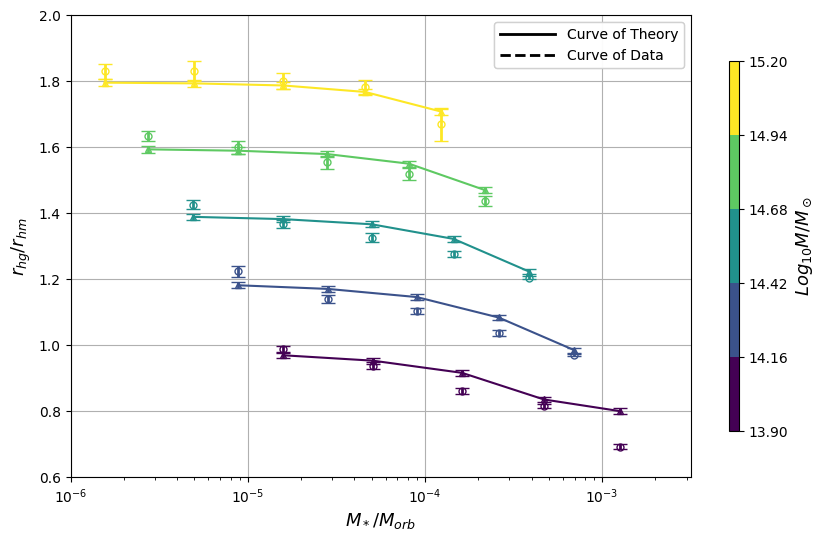

In [5]:
SRC_PATH = "/spiff/cwu18/project/halo_mass/mdpl2/corr_func"
filename = f"xihm_mdpl2_full.h5"
with h5.File(join(SRC_PATH, filename), "r") as f:
    logMBINEDGES = f["logMBINEDGES"][()]

path ='/spiff/cwu18/project/dynamical_friction/mdpl2/ratio_hghm_binbybin'
with h5.File(join(path, "ratio_smooth.h5"), "r") as f:
    ratio_data = f["ratio"][()]
    cov = f["cov"][()]

sigma_int = 0.01

DF_mdpl2.plt_DF(ratio_data, ratio_theory, cov, sigma_int, logMBINEDGES);

# mcmc

In [28]:
import matplotlib.ticker as ticker
from emcee.backends import HDFBackend

def DF_lkl(pars, *data):
    alpha, beta, lgsigma_int = pars
    ratio_data, cov, n_threads = data
    if alpha < -8 or alpha > -5 or beta < -6 or beta > -4 or lgsigma_int < -4 or lgsigma_int > 0:
        return -np.inf
    return DF_mdpl2.get_lglkl(alpha, beta, 10**lgsigma_int, ratio_data, cov, n_threads=n_threads)

def plt_chain(path, chain_file, chain_name, pars_name, fig, axes):
    """
    Plot the chains.

    Args:
        path (str): The path to the chain file.
        chain_name (str): The group name of the chain.
        pars_name (list): The names of the parameters.

    Returns:    
        fig, axes: The figure and axes.
    """
    sampler = HDFBackend(join(path, chain_file), name=chain_name, read_only=True)
    chains = sampler.get_chain()
    for i in range(len(pars_name)):
        ax = axes[i]
        ax.plot(chains[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(chains))
        ax.set_ylabel(pars_name[i])
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))


    axes[-1].set_xlabel("step number")
    return fig, axes


In [29]:
alpha = -6
beta = -5
lgsigma_int = -2
pars = [alpha, beta, lgsigma_int]

# =============================================================================
n_threads = 25
path ='/spiff/cwu18/project/dynamical_friction/mdpl2/ratio_hghm_binbybin'
with h5.File(join(path, "ratio_smooth.h5"), "r") as f:
    ratio_data = f["ratio"][()]
    cov = f["cov"][()]


In [30]:
from mcmc import run_chain

path = "/spiff/cwu18/project/dynamical_friction/mcmc/mdpl2"

chain_file = "chain100.h5"
chain_name = f"chain"

run_chain(
    path=path, 
    n_steps=100,  n_walkers=6,  n_cpu=6, n_dim= len(pars),
    log_prob=DF_lkl, 
    log_prob_args=[ratio_data, cov, n_threads], 
    pars_init=pars,
    chain_name=chain_name,
    chain_file=chain_file,
    )

# 10 steps (20 steps), 25 cpu, 6 cpu for 6 walkers
# cc, cc,  2m 11s, (3m 59.4s)
# mp, cc,  2m 4.5s, (3m 53.0s)
# bl, mp,  3m 55.2s
# bl, cc,  4m 52.9s


	 Initial log posterior -9.87


Chain chain: 100%|████████████████████████████████████████████████| 100/100 [17:02<00:00, 10.23s/it]


In [26]:
chain_file = "chain110.h5"
chain_name = f"chain"

restart_file = "chain100.h5"
restart_name = f"chain"

run_chain(
    path=path, 
    n_steps=10,  n_walkers=6, n_cpu=6, n_dim= len(pars),
    log_prob=DF_lkl, 
    log_prob_args=[ratio_data, cov, n_threads], 
    restart_file=restart_file,
    restart_name=restart_name,
    overwrite=True,
    chain_name=chain_name,
    chain_file=chain_file,
    )

# 10 steps (20 steps), 25 cpu, 6 cpu for 6 walkers
# cc, cc,  2m 11s, (3m 59.4s)
# mp, cc,  2m 4.5s, (3m 53.0s)
# bl, mp,  3m 55.2s
# bl, cc,  4m 52.9s


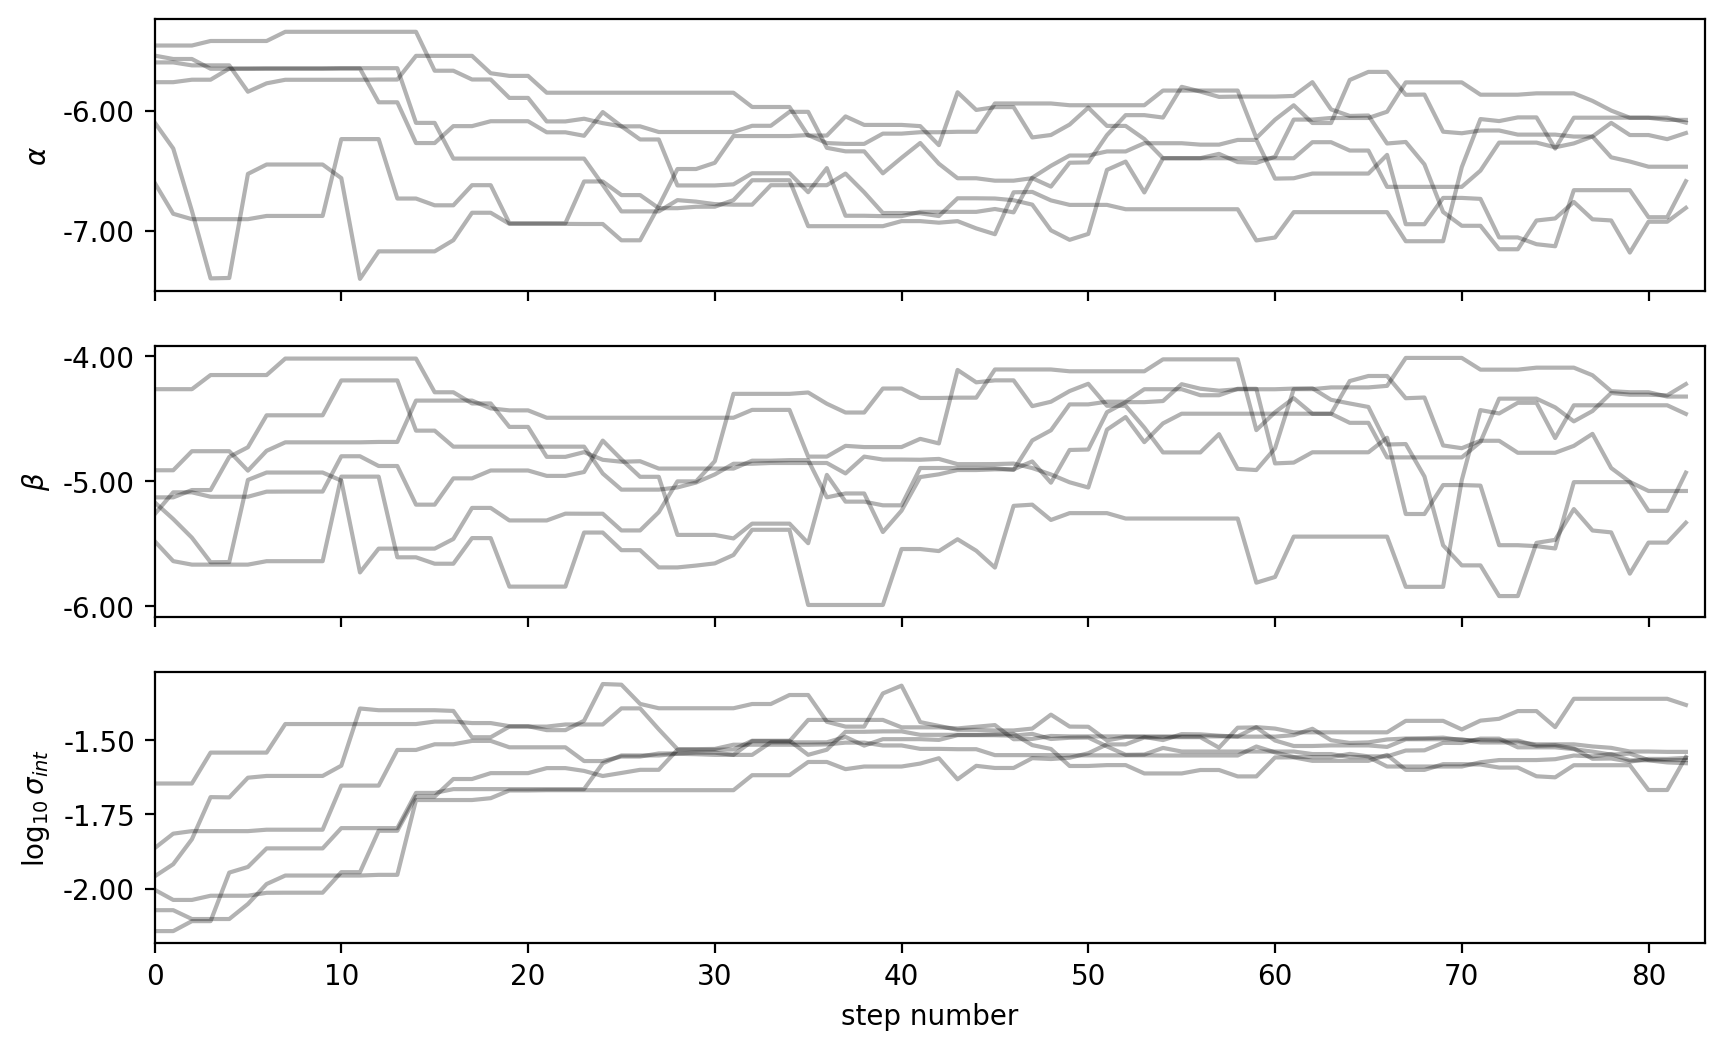

In [25]:
from matplotlib import pyplot as plt

chain_file = "chain100.h5"
chain_name = f"burn"

pars_name = ["alpha", "beta", "lgsigma_int"]
pars_name_STRS = [r"$\alpha$", r"$\beta$", r"$\log_{10}\sigma_{int}$"]

fig, axes = plt.subplots(len(pars_name), figsize=(10, 6), sharex=True)

fig, axes = plt_chain(path, chain_file, chain_name, pars_name_STRS, fig, axes)



In [13]:
from mcmc import summary

chain_file = "chain110.h5"
chain_name = "burn"
mle_file="mle110.h5"
mle_name="mle"
burn = 0.2
summary(
    path=path,  
    n_dim=len(pars), 
    chain_name=chain_name,  mle_name=mle_name, 
    chain_file=chain_file, mle_file=mle_file,
    burn=burn,
    )

Autocorrelation length 1.54


In [14]:
# quantiles (16, 50, 84).
with h5.File(join(path, mle_file), "r") as f:
    quantiles = f["quantiles"][mle_name][()]
    max_posterior = f["max_posterior"][mle_name][()]
    cov = f["covariance"][mle_name][()]
    mean = f["mean"][mle_name][()]

with h5.File(join(path, chain_file), "r") as f:
    chains = f[chain_name]["chain"][()]
    accpeted = f[chain_name]["accepted"][()]
acc = accpeted/chains.shape[0]
print(f'accpeted rate: {acc}')
print(f'max_posterior: {max_posterior}')
print(f'mean: {mean}')
print(f'quantiles: {quantiles}')
print(f'cov: {cov}')


accpeted rate: [0.4  0.46 0.37 0.44 0.44 0.52]
max_posterior: [-6.35926123 -4.62300693 -1.52504593]
mean: [-6.39432258 -4.80646868 -1.52341212]
quantiles: [[        nan -6.20221535         nan]
 [        nan -4.83863245         nan]
 [        nan -1.55087363         nan]]
cov: [[ 0.14989424  0.15905372 -0.00528493]
 [ 0.15905372  0.23464283 -0.00768986]
 [-0.00528493 -0.00768986  0.00504852]]


# triangle plot

In [15]:
burn = 0.2
chain_file = "chain100.h5"
chain_name = "chain"
sampler = HDFBackend(join(path, chain_file), name=chain_name, read_only=True)
flat_samples = sampler.get_chain(flat=True, discard=int(burn*sampler.iteration))
log_prob = sampler.get_log_prob(flat=True, discard=int(burn*sampler.iteration))

In [16]:
from getdist import plots, MCSamples
pars_name_STRS_getdist = [r"\alpha", r"\beta", r"\log_{10}\sigma_{int}"]
samples = MCSamples(samples=flat_samples, loglikes=log_prob, names = pars_name, labels = pars_name_STRS_getdist, settings={'ignore_rows':0})

Removed no burn in


In [17]:
stats  = samples.getLikeStats()
print(stats)

Best fit sample -log(Like) = 53.018006
Ln(mean 1/like) = 74.159301
mean(-Ln(like)) = 72.893105
-Ln(mean like)  = 58.319469
2*Var(Ln(like)) = 17.408870

parameter     bestfit        lower1         upper1         lower2         upper2
alpha        -5.5433837E+00 -7.1807464E+00 -5.5433837E+00 -7.1807464E+00 -5.5433837E+00   \alpha
beta         -4.3544362E+00 -5.9908134E+00 -4.0127925E+00 -5.9908134E+00 -4.0127925E+00   \beta
lgsigma_int  -1.7014417E+00 -1.7014417E+00 -1.3107366E+00 -1.7014417E+00 -1.3107366E+00   \log_{10}\sigma_{int}



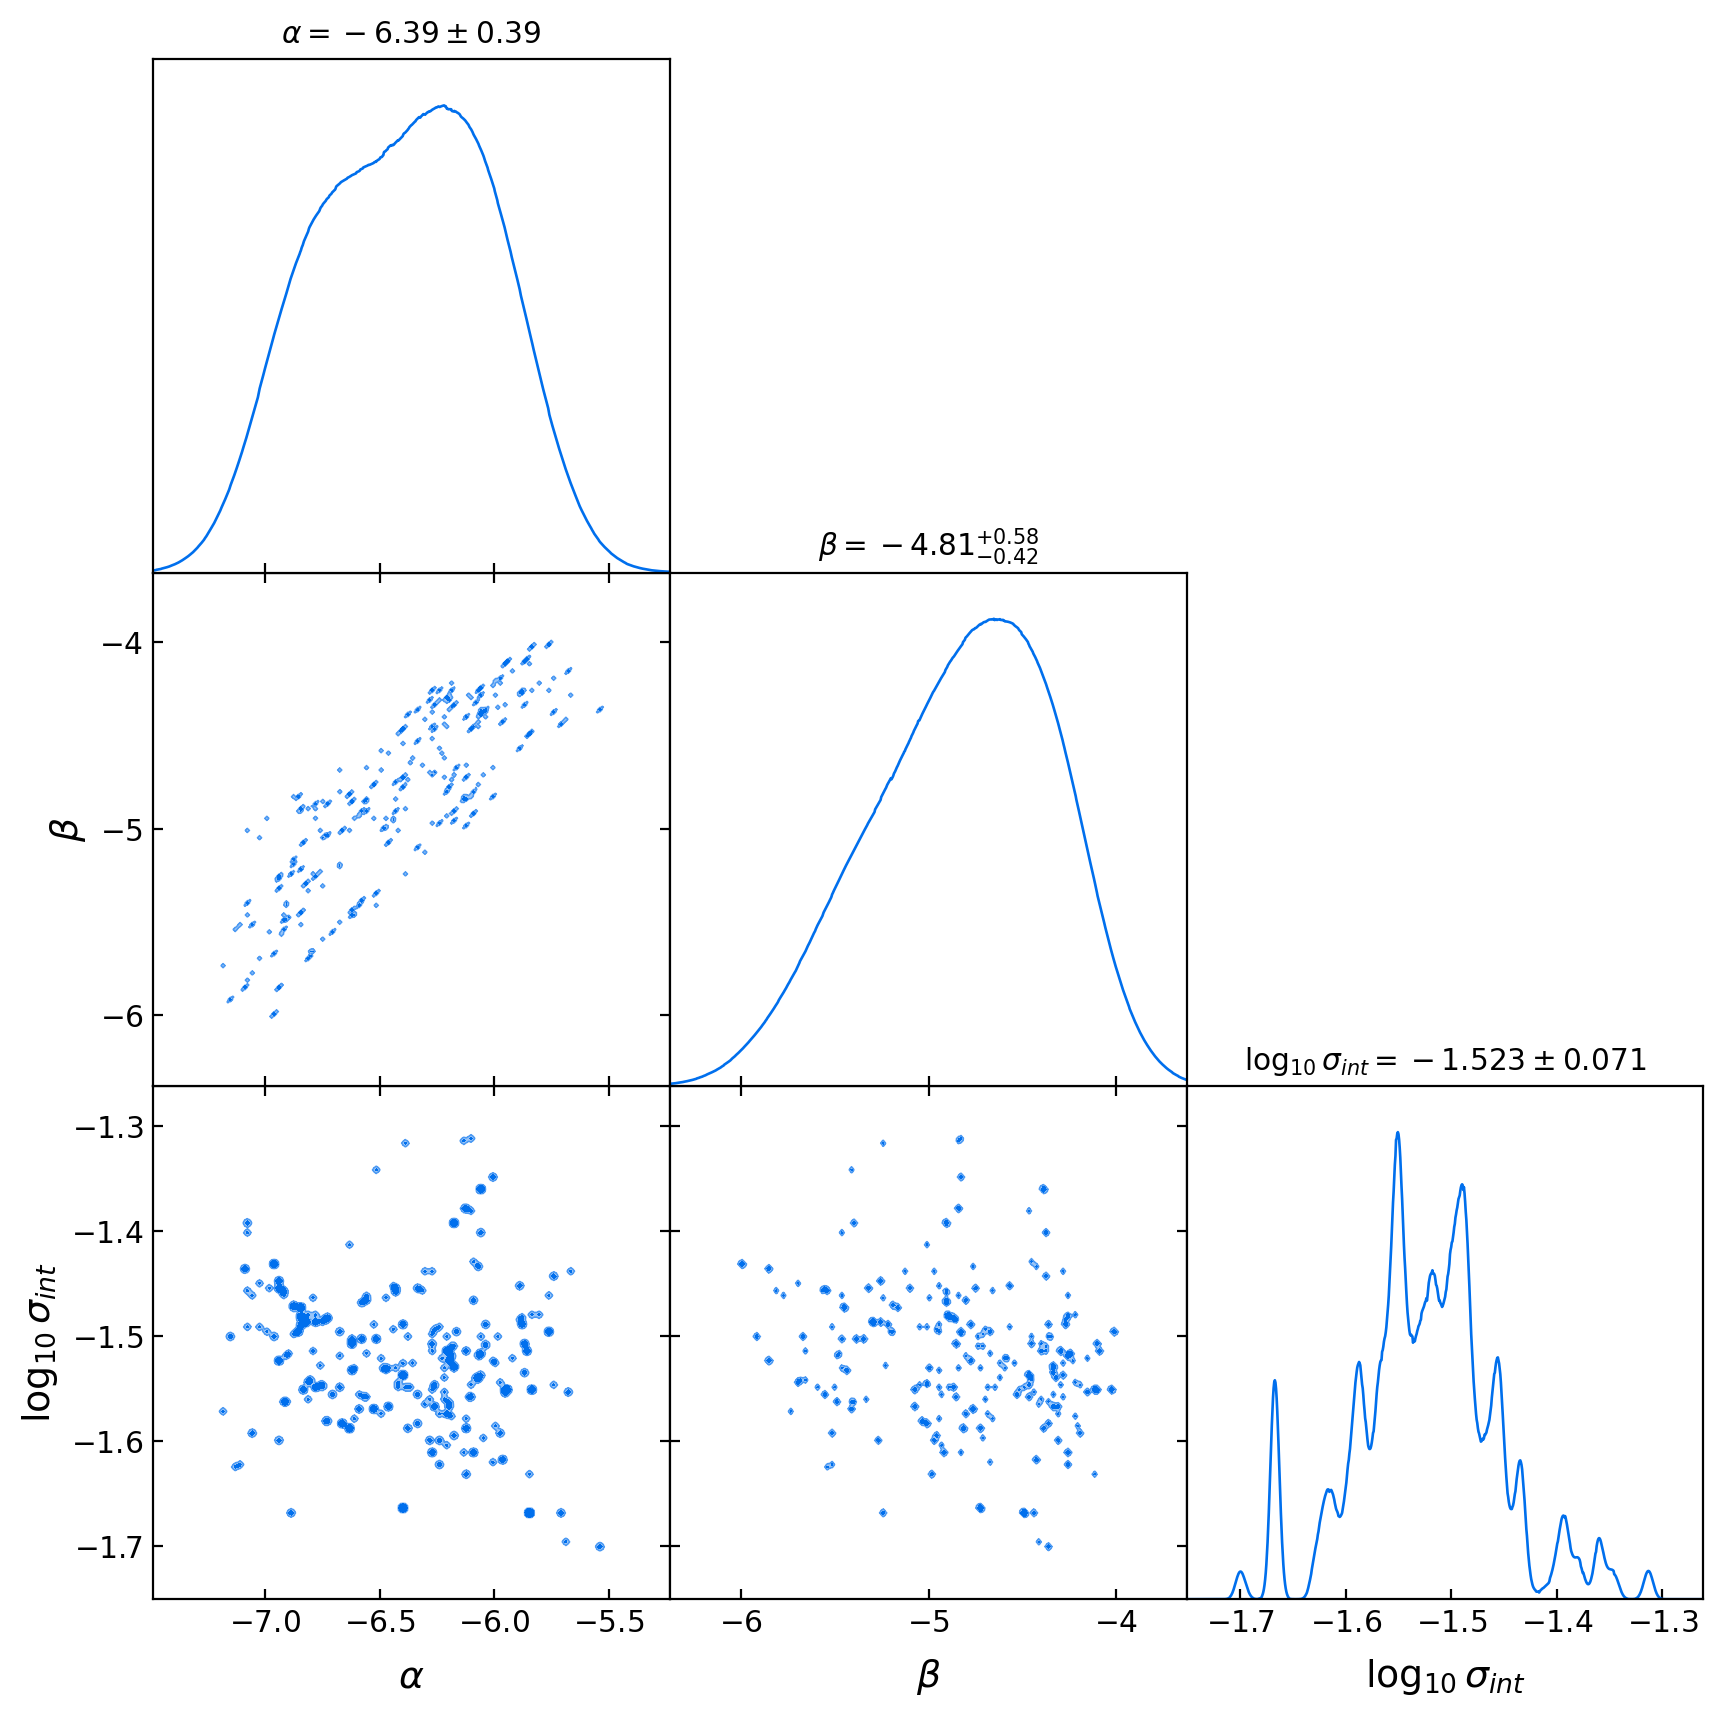

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

g = plots.get_subplot_plotter(width_inch=10)
g.triangle_plot(samples, filled=True,  title_limit=1)